Se desea simular la evolución de una epidemia, para lo cual se decide modelar las interacciones de una población de N
individuos distribuidos uniformemente sobre un área de 100 m x 100 m, simulando el desplazamiento de cada individuo
como un camino al azar en 2 dimensiones.
Se propone, modelar esta área como una grilla de celdas de 0,4 x 0,4 m, donde en cada celda sólo puede haber una
persona a la vez.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import log2, sqrt

In [3]:
area = 100 / 0.4
area

250.0

Si hay que modelar una grilla de 100 m x 100 m y cada celda tendrá 0,4 m x 0,4 m entonces voy a tener una grilla de 250 celdas por 250 celdas

In [56]:
N = 62500*2
flat_data = list(np.random.rand(N))
print(len(flat_data))

X, Y = [], []
for i in range (0, 250):
    for j in range (0, 250):
        test = np.random.rand()
        if test >= 0.95:
            X.append(flat_data.pop() + i*0.4)
            Y.append(flat_data.pop() + j*0.4)
        
            
print("Ok, y en este caso N es {0}".format(len(X)))

125000
Ok, y en este caso N es 3043


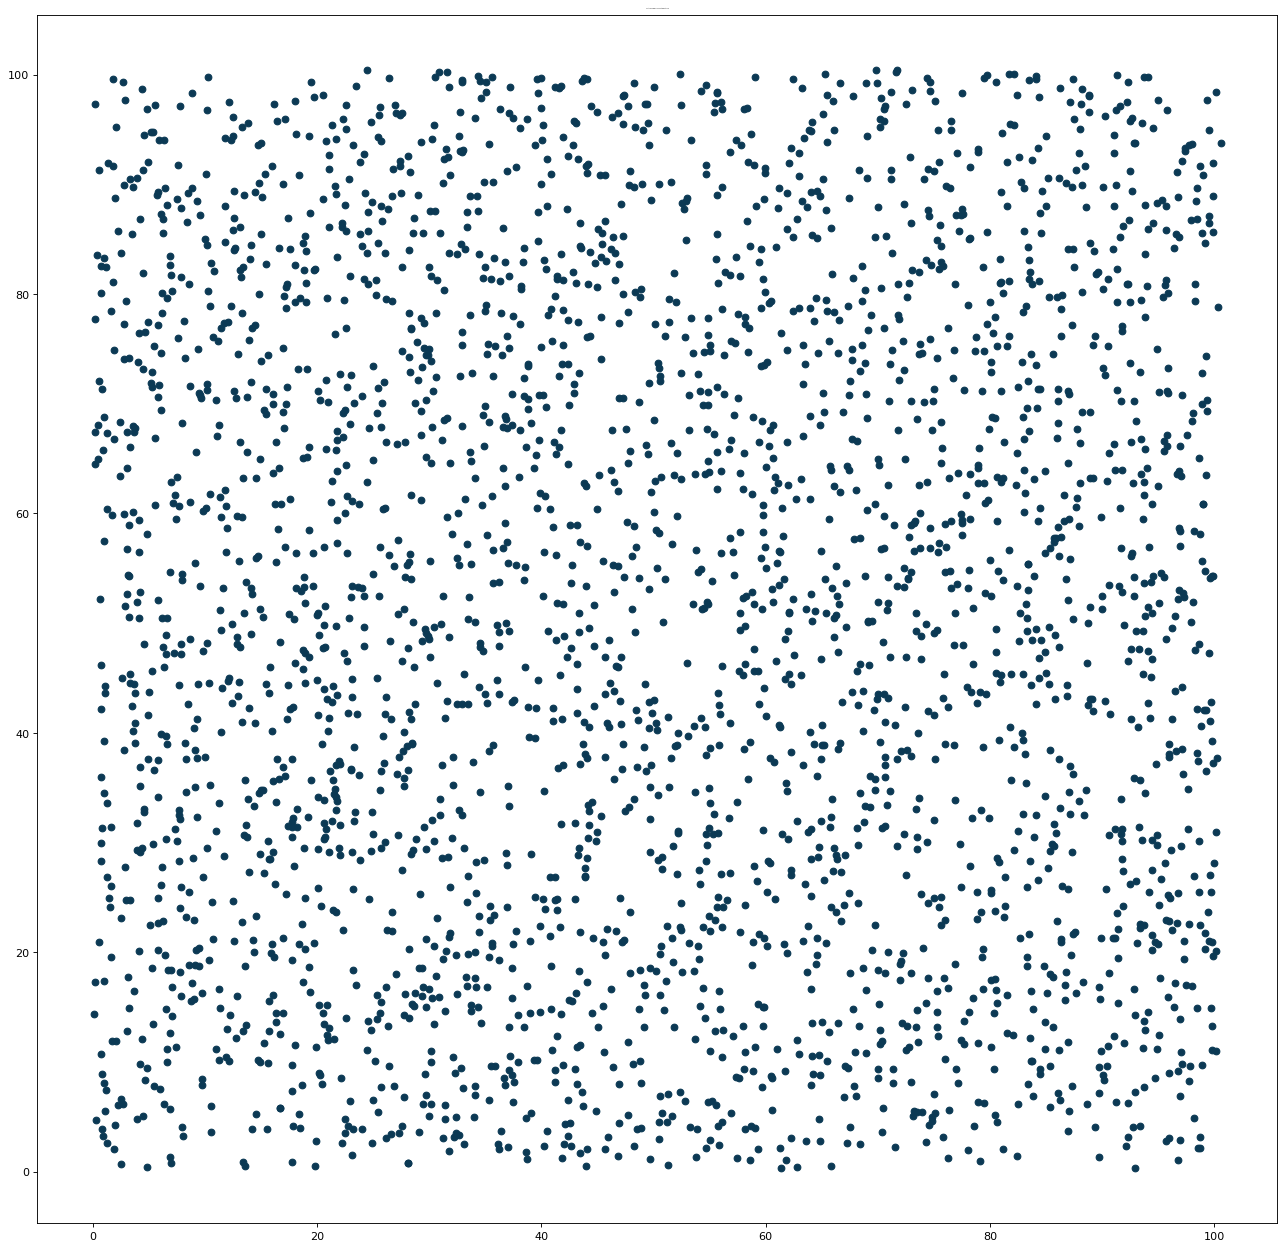

In [57]:
plt.figure(figsize=(20, 20), dpi=80)
plt.title('Puntos generados consecutivamente: 2D', size=0.01)
plt.scatter(X, Y, color='#0B3954')
plt.show()

Se considera que inicialmente el 3% de los individuos tiene la enfermedad, y existen 3 tipos e individuos:

Tipo - % - Características

A - 70 - Se mueve 1 celda por instante de tiempo

B - 20 - Se mueve 1 celda cada 2 instantes de tiempo

C - 10 - Se mueve 1 celda cada 4 instantes de tiempo
